# Solve *Easy21* by Tabular Montecarlo Control

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

sns.set()
%matplotlib inline

In [2]:
from plot_utils import draw_heatmap
from easy21 import Easy21, HIT, STICK

## Experiment of the easy21 env

In [3]:
env = Easy21()
print(env.num_actions)

2


In [4]:
env.render()

Player: 1, Dealer: 2


In [5]:
print(env.reset())
print(env.step(HIT))
print(env.step(STICK))

(9, 4)
((16, 4), 0.0, False, {})
((16, 17), -1.0, True, {})


## Epsilon greedy policy with decay

In [6]:
def EpsilonGreedyWithDecay(decay_rate, epsilon0):
    def epsilon_greedy_with_decay(qvalues, visits):
        epsilon = epsilon0 / (1.0 + decay_rate * sum(visits))
        n_actions = len(qvalues)
        probs = [epsilon / n_actions] * n_actions
        maxidx = qvalues.index(max(qvalues))
        probs[maxidx] += (1 - epsilon)
        return probs
    return epsilon_greedy_with_decay

In [7]:
explore_policy = EpsilonGreedyWithDecay(0.01, 1.0)

## Step size with decay

In [8]:
def StepSizeWithDecay(decay_rate, alpha0):
    def step_size_with_decay(visit, *args, **kwargs):
        return alpha0 / (1.0 + decay_rate * visit)
    return step_size_with_decay    

In [9]:
stepsize = StepSizeWithDecay(1.0, 1.0)

## Monte carlo control algorithm

Monte carlo control algorithm is as follows.

1. Initialize Q function.
2. Play the game with exploration policy and obtain the history of $\{(s_t, a_t, r_{t+1})\}_{t=1}^{T}$.
3. For each $t$, update the Q function by
$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \cdot \left( G_t - Q(s_t, a_t) \right),$$
where $G_t \equiv \sum_{\tau=t+1}^{T} \gamma^{\tau-t} r_{\tau}$
4. Finish if maximum number of iteration has reached, otherwise go to 2.

We will update backward at the step 3 so that we can calculate $G_t$ recursively.

In [10]:
def _episode(qs, ns, env, policy):
    s = env.reset()

    history = []
    while True:
        if s not in qs:
            qs[s] = [0.0] * env.num_actions
            ns[s] = [0.0] * env.num_actions

        # pick an action by epsilon greedy
        prob = policy(qs[s], ns[s])
        action = random.choices(range(env.num_actions), prob)[0]

        s1, r, done, _ = env.step(action)
        history.append((s, action, r, done))
        if done:
            break
        s = s1
    return history

def _update(qs, ns, history, stepsize, gamma=1.0):
    g = 0.0
    for s, a, r, d in reversed(history):
        g = gamma*g + r
        # step size
        alpha = stepsize(ns[s][a])
        delta = g - qs[s][a]
        qs[s][a] += alpha * delta
        
        # increment visit count
        ns[s][a] += 1.0

In [11]:
qs = {}
ns = {}

In [12]:
for i in tqdm(range(10**6)):
    history = _episode(qs, ns, env, explore_policy)
    _update(qs, ns, history, stepsize)

In [13]:
def to_state_value(qs):
    v = np.zeros((21, 10))
    for s, q in qs.items():
        player, dealer = s
        v[player-1, dealer-1] = max(q)
    return v

def to_policy(qs):
    policy = np.zeros((21, 10), dtype=int)
    for s, q in qs.items():
        player, dealer = s
        policy[player-1, dealer-1] = q.index(max(q))
    return policy

def to_q_array(qs):
    q_array = np.zeros((21, 10, 2))
    for s, q in qs.items():
        player, dealer = s
        q_array[player-1, dealer-1] = q
    return q_array

def to_q_diff(qs):
    q_array = to_q_array(qs)
    return q_array[:,:,1] - q_array[:,:,0]

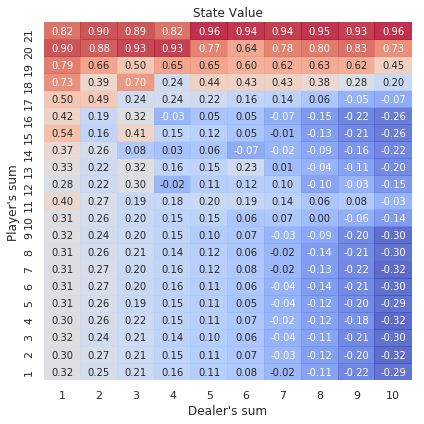

In [14]:
V = to_state_value(qs)

fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V, ax=ax, title="State Value")
fig.tight_layout()
None

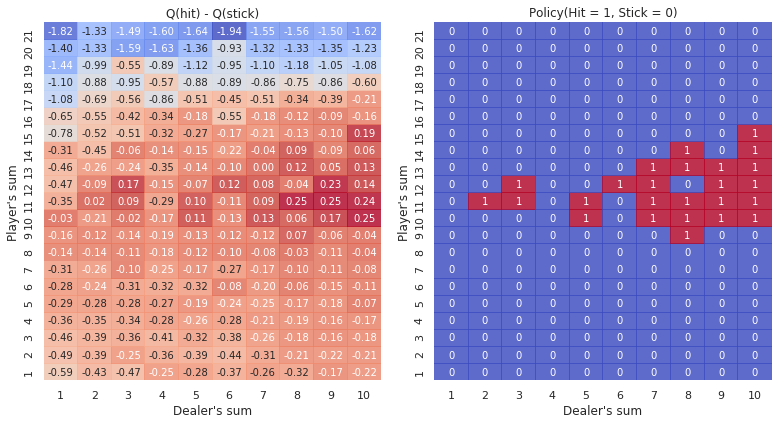

In [15]:
q_diff = to_q_diff(qs)
policy = to_policy(qs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None

*Remark: The result is qualitatively close to the DP result, but seems still not yet converged after 10^6 iterations.*

## Comparison to the DP result

We will now compare the monte carlo control results with that of dynamic programming.
Here, we regard the DP result as "correct"; Since it has been already converged to the fixed point of the Bellman optimality equation, it is the solution (unless there is a bug in the DP implementation).

Every 1000 iteration, we will calculate the mean absolute difference between two Q-functions, and see how this "error" changes along the iterations.

In [16]:
f = np.load("result/dp.npz")
Q_dp = f["Q"]
Q_dp.shape

(21, 10, 2)

In [17]:
qs = {}
ns = {}
maes = []

In [18]:
for i in tqdm(range(10**7)):
    history = _episode(qs, ns, env, explore_policy)
    _update(qs, ns, history, stepsize)
    if i % 1000 == 0:
        q_array = to_q_array(qs)
        maes.append(np.mean(np.abs(q_array - Q_dp)))

Final error = 0.06238075651113639


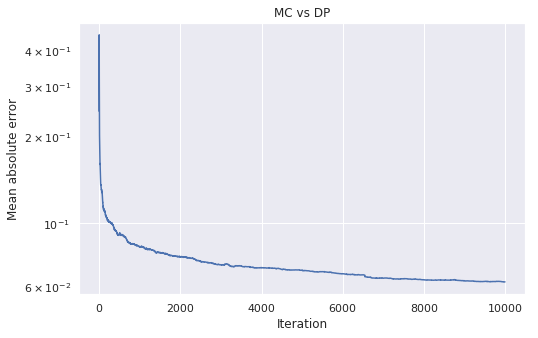

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(maes)
ax.set_yscale("log")
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean absolute error")
ax.set_title("MC vs DP")

print("Final error =", maes[-1])

*Remark: The "error" is decreasing along the iteration, but it seems to have still a long way until complete convergence.*

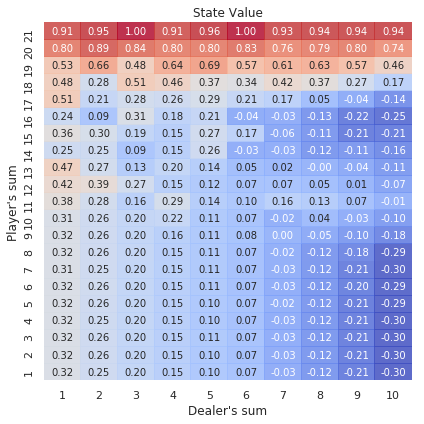

In [20]:
V = to_state_value(qs)

fig, ax = plt.subplots(figsize=(6, 6))
draw_heatmap(V, ax=ax, title="State Value")
fig.tight_layout()
None

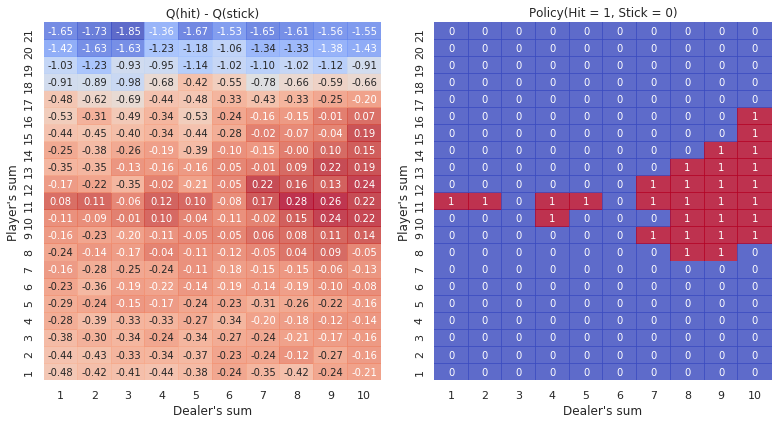

In [21]:
q_diff = to_q_diff(qs)
policy = to_policy(qs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))
draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()
None